In [76]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np


In [30]:
train_raw = pd.read_csv('../train_clean.csv')
test_raw = pd.read_csv('../test_clean.csv')

In [78]:
train_raw.head()

,Survived,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,1,0,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,0,1,0,1
3,1,35.0,1,0,53.1000,0,0,1,0,0
4,0,35.0,0,0,8.0500,1,0,1,0,1


## Standardize

In [32]:
# train
train_features = train_raw.drop('Survived', axis=1)
train_labels = train_raw['Survived']

# test
test_features = test_raw.drop('Survived', axis=1) 
test_labels = test_raw['Survived']

scaler = StandardScaler()

train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

train_features_standarized = pd.DataFrame(train_features_scaled, columns=train_features.columns)
train_standarized = pd.concat([train_features_standarized, train_labels], axis=1)

test_features_standarized = pd.DataFrame(test_features_scaled, columns=test_features.columns)
test_standarized = pd.concat([test_features_standarized, test_labels], axis=1)


## Select best K

In [33]:
# Split the training data into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(train_features_scaled, train_labels, test_size=0.2, random_state=42)

#Train the KNN model with different values of k.

# Define the range of k values to test.
k_range = range(1, 31)
train_errors = []
val_errors = []


for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Training error
    y_train_pred = knn.predict(X_train)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    
    # Validation error
    y_val_pred = knn.predict(X_val)
    val_errors.append(mean_squared_error(y_val, y_val_pred))


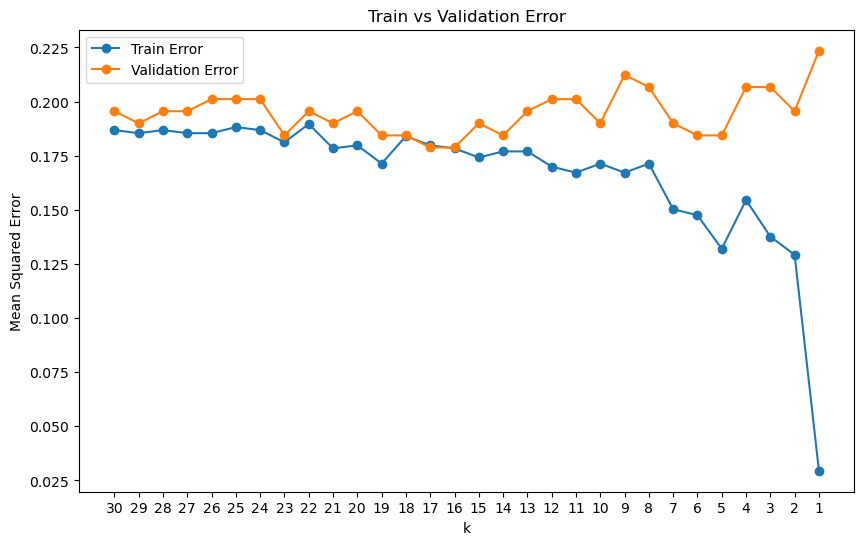

In [34]:
# plot results
plt.figure(figsize=(10, 6))
plt.plot(k_range[::-1], train_errors[::-1], label='Train Error', marker='o')
plt.plot(k_range[::-1], val_errors[::-1], label='Validation Error', marker='o')
plt.xlabel('k')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Validation Error')
plt.legend()
plt.xticks(ticks=k_range[::-1], labels=k_range[::-1])  # Ensure k values are shown from 30 to 1
plt.gca().invert_xaxis()
plt.show()


In [35]:
best_k = k_range[val_errors.index(min(val_errors))]
print(f'The best value of k is: {best_k}')

The best value of k is: 16


## Cross-Validation Protocols

In [66]:
# Model
knn = KNeighborsClassifier(n_neighbors=best_k)

In [67]:
# 5-Fold Cross-Validation
cv_5_scores = cross_val_score(knn, train_features_scaled, train_labels, cv=5, scoring='accuracy')
print(f'5-Fold Cross-Validation Accuracy: {cv_5_scores.mean()}')

5-Fold Cross-Validation Accuracy: 0.799114933149206


In [68]:
# 10-Fold Cross-Validation
cv_10_scores = cross_val_score(knn, train_features_scaled, train_labels, cv=10, scoring='accuracy')
print(f'10-Fold Cross-Validation Accuracy: {cv_10_scores.mean()}')

10-Fold Cross-Validation Accuracy: 0.8103495630461921


## Fit the model

In [69]:
knn.fit(train_features_scaled, train_labels)

KNeighborsClassifier(n_neighbors=16)

In [70]:
# Predict on the validation set
y_val_pred = knn.predict(X_val)

In [71]:
conf_matrix = confusion_matrix(y_val, y_val_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

Confusion Matrix:
[[97  8]
 [22 52]]


In [72]:
class_report = classification_report(y_val, y_val_pred)
print(f'Classification Report:\n{class_report}')

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       105
           1       0.87      0.70      0.78        74

    accuracy                           0.83       179
   macro avg       0.84      0.81      0.82       179
weighted avg       0.84      0.83      0.83       179



## Predict on Test set

In [73]:
test_predictions = knn.predict(test_features_scaled)

In [74]:
conf_matrix = confusion_matrix(test_labels, test_predictions)
print(f'Confusion Matrix:\n{conf_matrix}')

Confusion Matrix:
[[193  11]
 [ 31  96]]


In [75]:
class_report = classification_report(test_labels, test_predictions)
print(f'Classification Report:\n{class_report}')

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       204
           1       0.90      0.76      0.82       127

    accuracy                           0.87       331
   macro avg       0.88      0.85      0.86       331
weighted avg       0.88      0.87      0.87       331



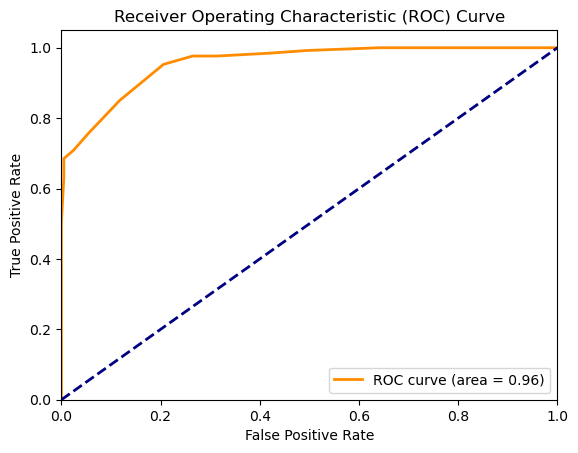

In [77]:
# Compute ROC curve and ROC area
test_probabilities = knn.predict_proba(test_features_scaled)[:, 1] 
fpr, tpr, _ = roc_curve(test_labels, test_probabilities)
roc_auc = roc_auc_score(test_labels, test_probabilities)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()